# NBA Playoff Prediction - K-Nearest Neighbors

This notebook implements K-Nearest Neighbors (KNN) for predicting NBA playoff qualification.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')


In [29]:
# Load all 4 feature transformation versions
data_versions = {
    'baseline': ('scaled', 'Baseline (untransformed)'),
    'poly2': ('poly2', 'Polynomial degree 2'),
    'poly3': ('poly3', 'Polynomial degree 3'),
    'pca': ('pca', 'PCA (95% variance)')
}

# Load labels (same for all versions)
y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

# Load all versions
X_data = {}
for name, (suffix, desc) in data_versions.items():
    X_data[name] = {
        'train': np.load(f'data/processed/X_train_{suffix}.npy'),
        'val': np.load(f'data/processed/X_val_{suffix}.npy'),
        'test': np.load(f'data/processed/X_test_{suffix}.npy'),
        'desc': desc
    }
    print(f"{desc}: Train={X_data[name]['train'].shape}, Val={X_data[name]['val'].shape}, Test={X_data[name]['test'].shape}")

# Set X_train, X_val, X_test to baseline for compatibility (will be overridden in loops)
X_train = X_data['baseline']['train']
X_val = X_data['baseline']['val']
X_test = X_data['baseline']['test']


Baseline (untransformed): Train=(446, 32), Val=(120, 32), Test=(120, 32)
Polynomial degree 2: Train=(446, 560), Val=(120, 560), Test=(120, 560)
Polynomial degree 3: Train=(446, 6544), Val=(120, 6544), Test=(120, 6544)
PCA (95% variance): Train=(446, 14), Val=(120, 14), Test=(120, 14)


## Model Evaluation


In [30]:
# Evaluate on train, validation, and test sets
def evaluate_knn(k, metric='euclidean', weights='uniform', X_train=X_train, y_train=y_train, 
                X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test):
    """
    Train and evaluate KNN model on train, validation, and test sets.
    """
    # Train model
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn.fit(X_train, y_train)
    
    results = {}
    
    # Evaluate on each set
    for name, X_data, y_data in [('train', X_train, y_train), 
                                  ('val', X_val, y_val), 
                                  ('test', X_test, y_test)]:
        y_pred = knn.predict(X_data)
        y_pred_proba = knn.predict_proba(X_data)[:, 1]
        
        acc = accuracy_score(y_data, y_pred)
        prec = precision_score(y_data, y_pred, zero_division=0)
        rec = recall_score(y_data, y_pred, zero_division=0)
        f1 = f1_score(y_data, y_pred, zero_division=0)
        
        try:
            auc = roc_auc_score(y_data, y_pred_proba)
        except:
            auc = 0
        
        results[name] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'auc': auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
    
    return knn, results


## Hyperparameter Tuning


In [31]:
# Try different hyperparameter combinations
k_values = [1, 3, 5, 7, 9, 11, 15, 21]
metrics = ['euclidean', 'manhattan']
weights_options = ['uniform', 'distance']

results = []

print("Hyperparameter Tuning: Testing different K, metric, and weight combinations across all feature transformations")
print("=" * 80)

for version_name, (suffix, version_desc) in data_versions.items():
    print(f"\n{'='*80}")
    print(f"Feature Transformation: {version_desc}")
    print(f"{'='*80}")
    
    # Use this version's data
    X_train = X_data[version_name]['train']
    X_val = X_data[version_name]['val']
    X_test = X_data[version_name]['test']
    
    for k in k_values:
        for metric in metrics:
            for weights in weights_options:
                # Train and evaluate on validation set
                knn, eval_results = evaluate_knn(k, metric, weights, 
                                               X_train, y_train, 
                                               X_val, y_val, 
                                               X_test, y_test)
                
                val_results = eval_results['val']
                
                results.append({
                    'version': version_name,
                    'version_desc': version_desc,
                    'k': k,
                    'metric': metric,
                    'weights': weights,
                    'accuracy': val_results['accuracy'],
                    'precision': val_results['precision'],
                    'recall': val_results['recall'],
                    'f1': val_results['f1'],
                    'auc': val_results['auc']
                })
                
                print(f"K={k:2d}, Metric={metric:10s}, Weights={weights:8s}: "
                      f"Acc={val_results['accuracy']:.4f}, F1={val_results['f1']:.4f}, "
                      f"AUC={val_results['auc']:.4f}")

# Find best model based on AUC score
results_df = pd.DataFrame(results)
best_idx = results_df['auc'].idxmax()
best_version = results_df.loc[best_idx, 'version']
best_version_desc = results_df.loc[best_idx, 'version_desc']
best_k = results_df.loc[best_idx, 'k']
best_metric = results_df.loc[best_idx, 'metric']
best_weights = results_df.loc[best_idx, 'weights']
best_auc = results_df.loc[best_idx, 'auc']

print(f"\n{'='*80}")
print(f"Best model (selected by AUC score): {best_version_desc}, K={best_k}, Metric={best_metric}, Weights={best_weights} (AUC={best_auc:.4f})")
print(f"{'='*80}")
print(f"Validation metrics at best model:")
print(f"  Accuracy: {results_df.loc[best_idx, 'accuracy']:.4f}")
print(f"  Precision: {results_df.loc[best_idx, 'precision']:.4f}")
print(f"  Recall: {results_df.loc[best_idx, 'recall']:.4f}")
print(f"  F1 Score: {results_df.loc[best_idx, 'f1']:.4f}")
print(f"  AUC: {results_df.loc[best_idx, 'auc']:.4f}")


Hyperparameter Tuning: Testing different K, metric, and weight combinations across all feature transformations

Feature Transformation: Baseline (untransformed)
K= 1, Metric=euclidean , Weights=uniform : Acc=0.7833, F1=0.8060, AUC=0.7790
K= 1, Metric=euclidean , Weights=distance: Acc=0.7833, F1=0.8060, AUC=0.7790
K= 1, Metric=manhattan , Weights=uniform : Acc=0.8333, F1=0.8551, AUC=0.8270
K= 1, Metric=manhattan , Weights=distance: Acc=0.8333, F1=0.8551, AUC=0.8270
K= 3, Metric=euclidean , Weights=uniform : Acc=0.8167, F1=0.8451, AUC=0.8686
K= 3, Metric=euclidean , Weights=distance: Acc=0.8167, F1=0.8451, AUC=0.8687
K= 3, Metric=manhattan , Weights=uniform : Acc=0.8500, F1=0.8676, AUC=0.8952
K= 3, Metric=manhattan , Weights=distance: Acc=0.8500, F1=0.8676, AUC=0.9035
K= 5, Metric=euclidean , Weights=uniform : Acc=0.8083, F1=0.8369, AUC=0.8878
K= 5, Metric=euclidean , Weights=distance: Acc=0.8083, F1=0.8369, AUC=0.8896
K= 5, Metric=manhattan , Weights=uniform : Acc=0.8417, F1=0.8613, AUC

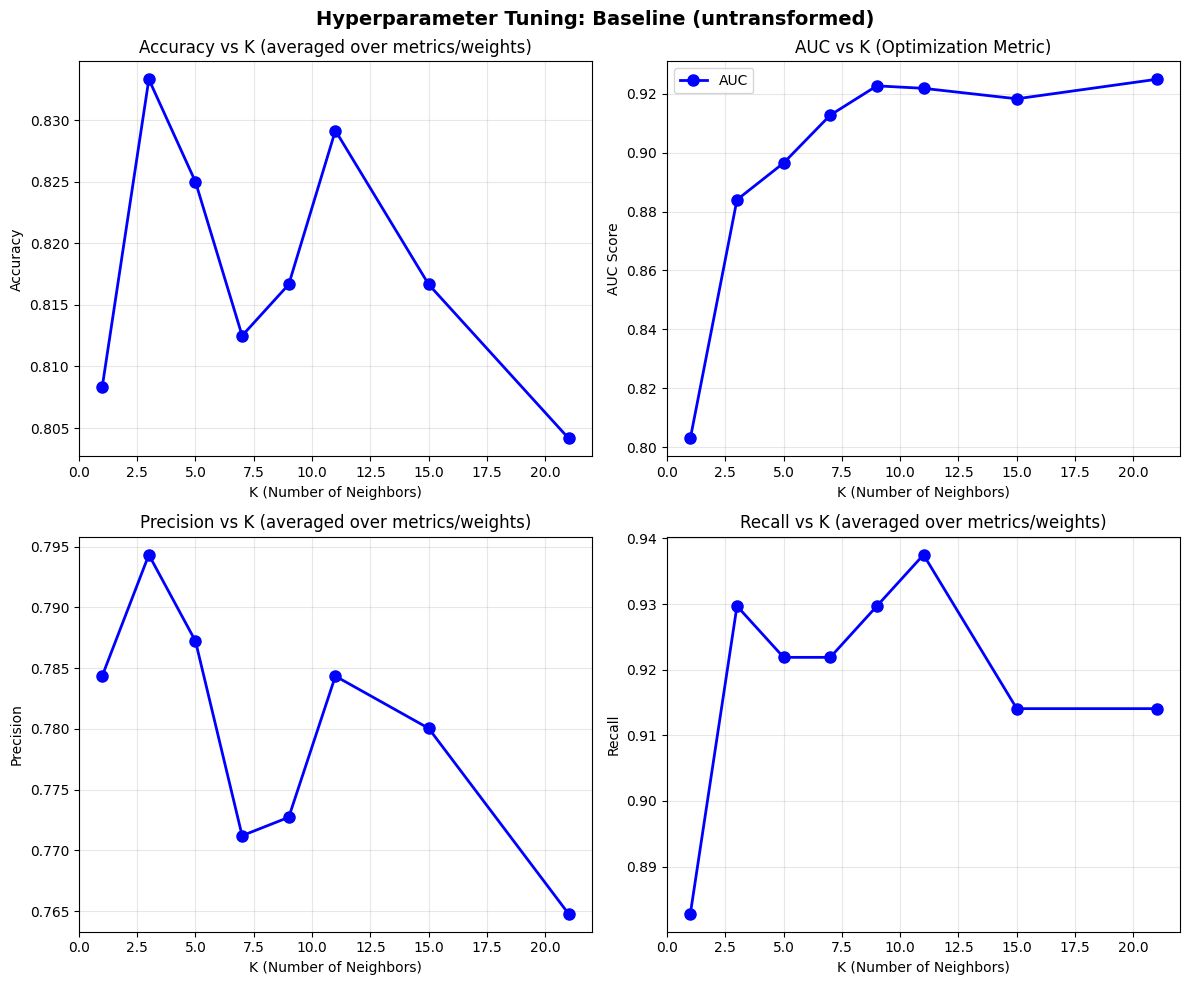

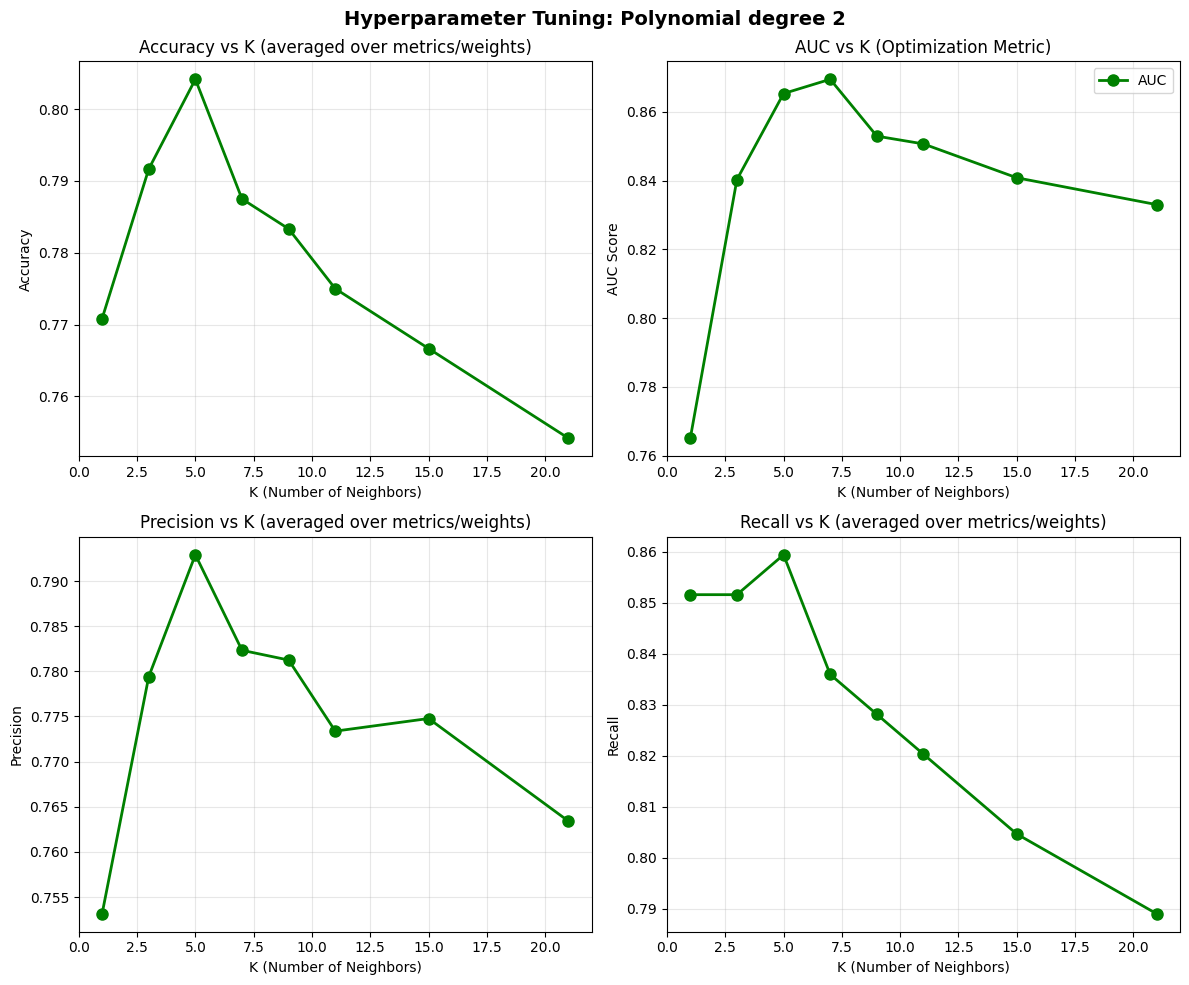

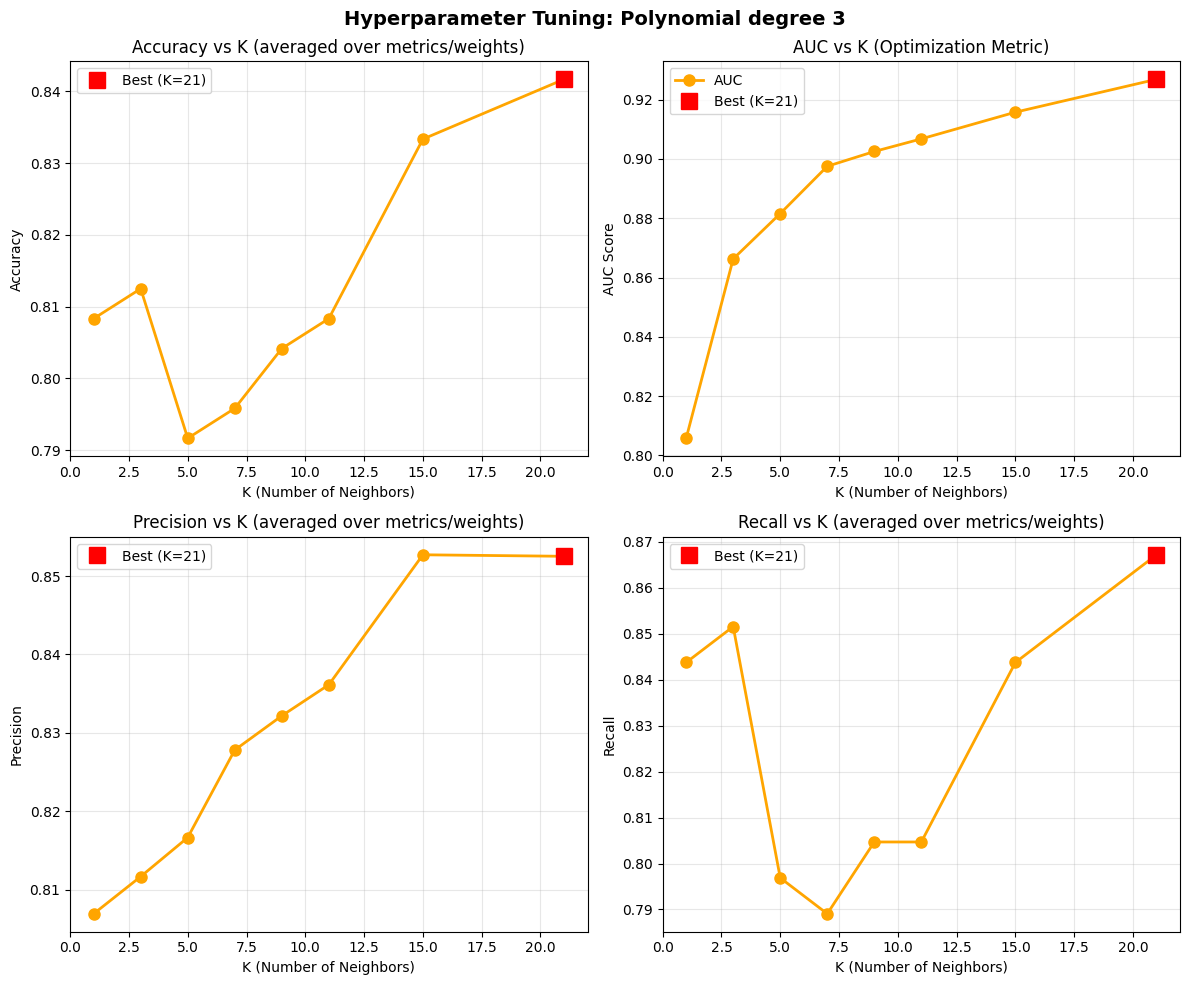

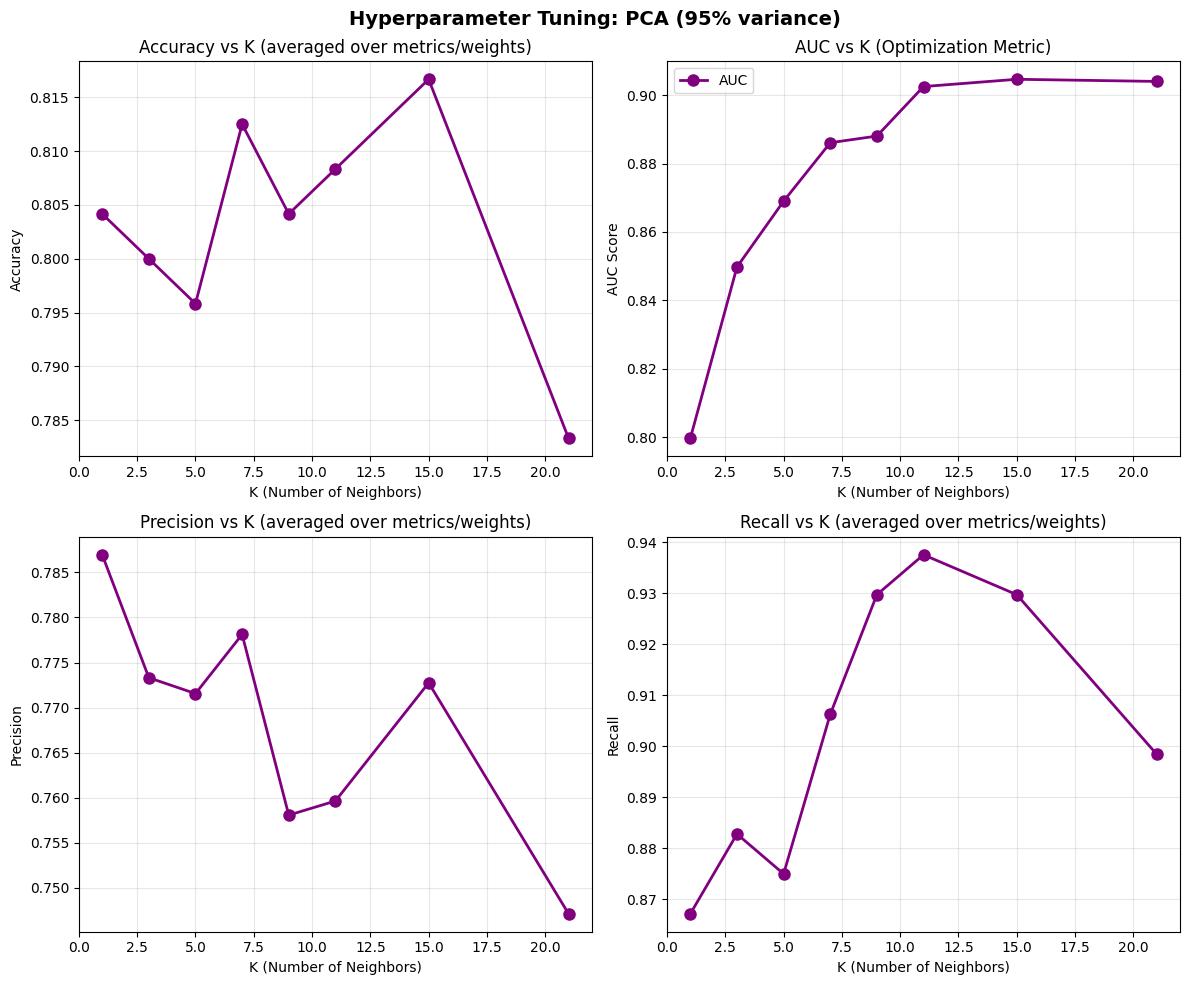

In [37]:
# Plot hyperparameter tuning results - one figure per feature transformation
version_colors = {
    'Baseline (untransformed)': 'blue',
    'Polynomial degree 2': 'green',
    'Polynomial degree 3': 'orange',
    'PCA (95% variance)': 'purple'
}

# Create one figure per version
for version_desc in results_df['version_desc'].unique():
    version_data = results_df[results_df['version_desc'] == version_desc].copy()
    
    # Group by k and calculate mean metrics for this version
    k_summary = version_data.groupby('k').agg({
        'accuracy': 'mean',
        'f1': 'mean',
        'auc': 'mean',
        'precision': 'mean',
        'recall': 'mean'
    }).reset_index()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Hyperparameter Tuning: {version_desc}', fontsize=14, fontweight='bold')
    
    # Check if this version has the best k
    is_best_version = (version_desc == best_version_desc)
    if is_best_version:
        best_k_summary = k_summary[k_summary['k'] == best_k]
    
    color = version_colors[version_desc]
    
    # Accuracy plot
    axes[0, 0].plot(k_summary['k'], k_summary['accuracy'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version and len(best_k_summary) > 0:
        axes[0, 0].plot(best_k, best_k_summary['accuracy'].values[0], 's', markersize=12, color='red', label=f'Best (K={best_k})', zorder=5)
        axes[0, 0].legend()
    axes[0, 0].set_xlabel('K (Number of Neighbors)')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy vs K (averaged over metrics/weights)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # AUC plot (optimization metric) - highlight best point
    axes[0, 1].plot(k_summary['k'], k_summary['auc'], 'o-', linewidth=2, markersize=8, color=color, label='AUC')
    if is_best_version and len(best_k_summary) > 0:
        axes[0, 1].plot(best_k, best_k_summary['auc'].values[0], 's', markersize=12, color='red', label=f'Best (K={best_k})', zorder=5)
    axes[0, 1].set_xlabel('K (Number of Neighbors)')
    axes[0, 1].set_ylabel('AUC Score')
    axes[0, 1].set_title('AUC vs K (Optimization Metric)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Precision plot
    axes[1, 0].plot(k_summary['k'], k_summary['precision'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version and len(best_k_summary) > 0:
        best_prec_plot = best_k_summary['precision'].values[0]
        axes[1, 0].plot(best_k, best_prec_plot, 's', markersize=12, color='red', label=f'Best (K={best_k})', zorder=5)
        axes[1, 0].legend()
    axes[1, 0].set_xlabel('K (Number of Neighbors)')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision vs K (averaged over metrics/weights)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall plot
    axes[1, 1].plot(k_summary['k'], k_summary['recall'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version and len(best_k_summary) > 0:
        best_rec_plot = best_k_summary['recall'].values[0]
        axes[1, 1].plot(best_k, best_rec_plot, 's', markersize=12, color='red', label=f'Best (K={best_k})', zorder=5)
        axes[1, 1].legend()
    axes[1, 1].set_xlabel('K (Number of Neighbors)')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Recall vs K (averaged over metrics/weights)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Final Model with Best Hyperparameters


In [33]:
# Use best version's data
X_train = X_data[best_version]['train']
X_val = X_data[best_version]['val']
X_test = X_data[best_version]['test']

# Train final model with best hyperparameters (selected by AUC score on validation set)
print(f"Training final model: {best_version_desc}, K={best_k}, Metric={best_metric}, Weights={best_weights} (AUC={best_auc:.4f} on validation)")

best_knn, final_results = evaluate_knn(best_k, best_metric, best_weights,
                                      X_train, y_train,
                                      X_val, y_val,
                                      X_test, y_test)

# Evaluate on test set
test_results = final_results['test']

print("\nFinal Test Set Results:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")
print(f"AUC: {test_results['auc']:.4f}")

cm = confusion_matrix(y_test, test_results['y_pred'])
print(f"\nConfusion Matrix:")
print(cm)


Training final model: Polynomial degree 3, K=21, Metric=manhattan, Weights=distance (AUC=0.9648 on validation)

Final Test Set Results:
Accuracy: 0.7667
Precision: 0.7000
Recall: 0.9844
F1 Score: 0.8182
AUC: 0.9640

Confusion Matrix:
[[29 27]
 [ 1 63]]


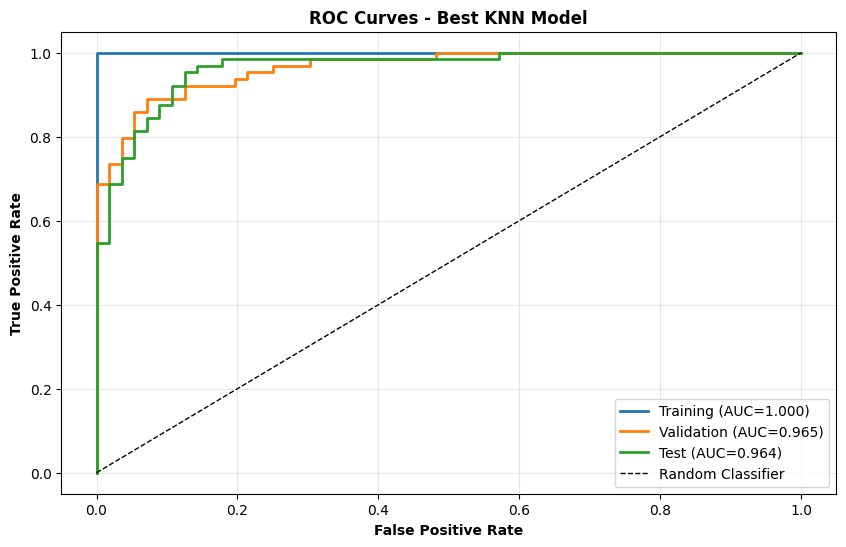

In [34]:
# ROC Curves for Train, Val, Test sets
plt.figure(figsize=(10, 6))

for name, results_dict in [('Training', final_results['train']),
                           ('Validation', final_results['val']),
                           ('Test', final_results['test'])]:
    y_true = y_train if name == 'Training' else (y_val if name == 'Validation' else y_test)
    y_prob = results_dict['y_pred_proba']
    
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)
    except:
        pass

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves - Best KNN Model', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


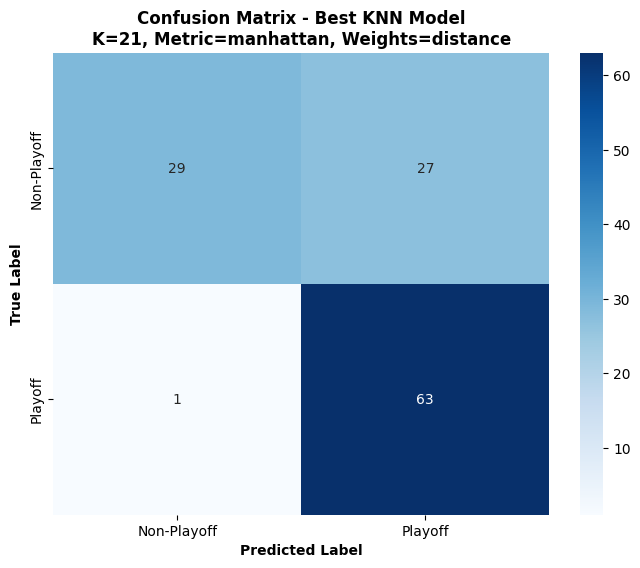

In [35]:
# Confusion Matrix Heatmap
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Playoff', 'Playoff'],
            yticklabels=['Non-Playoff', 'Playoff'])
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.title(f'Confusion Matrix - Best KNN Model\nK={best_k}, Metric={best_metric}, Weights={best_weights}',
          fontweight='bold')
plt.show()


## Detailed Results


In [36]:
print("\n" + "=" * 80)
print("DETAILED RESULTS: KNN (Hyperparameter Sweep - Validation Set)")
print("=" * 80)
print("(Best model selected based on AUC)")
print("=" * 80)
# Sort by AUC to show best at top, then by k
results_df_sorted = results_df.sort_values(['auc', 'k'], ascending=[False, True])
print(results_df_sorted[['k', 'metric', 'weights', 'accuracy', 'precision', 'recall', 'f1', 'auc']].to_string(index=False))

print("\n" + "=" * 80)
print("PERFORMANCE (Validation) BY K")
print("=" * 80)
k_stats = results_df.groupby('k').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max'],
    'auc': ['mean', 'std', 'min', 'max']
}).round(4)
print(k_stats)

print("\n" + "=" * 80)
print("PERFORMANCE (Validation) BY METRIC")
print("=" * 80)
metric_stats = results_df.groupby('metric').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max'],
    'auc': ['mean', 'std', 'min', 'max']
}).round(4)
print(metric_stats)

print("\n" + "=" * 80)
print("PERFORMANCE (Validation) BY WEIGHTS")
print("=" * 80)
weights_stats = results_df.groupby('weights').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max'],
    'auc': ['mean', 'std', 'min', 'max']
}).round(4)
print(weights_stats)



DETAILED RESULTS: KNN (Hyperparameter Sweep - Validation Set)
(Best model selected based on AUC)
 k    metric  weights  accuracy  precision   recall       f1      auc
21 manhattan distance  0.900000   0.948276 0.859375 0.901639 0.964844
21 manhattan  uniform  0.900000   0.948276 0.859375 0.901639 0.964146
15 manhattan distance  0.900000   0.948276 0.859375 0.901639 0.962612
15 manhattan  uniform  0.900000   0.948276 0.859375 0.901639 0.961077
11 manhattan distance  0.833333   0.892857 0.781250 0.833333 0.945871
 9 manhattan distance  0.850000   0.910714 0.796875 0.850000 0.943359
 9 manhattan  uniform  0.850000   0.910714 0.796875 0.850000 0.942801
11 manhattan  uniform  0.833333   0.892857 0.781250 0.833333 0.941964
21 manhattan distance  0.816667   0.776316 0.921875 0.842857 0.938895
21 manhattan  uniform  0.816667   0.776316 0.921875 0.842857 0.935965
 9 manhattan distance  0.808333   0.766234 0.921875 0.836879 0.931362
 7 manhattan distance  0.825000   0.890909 0.765625 0.823529 0